In [1]:
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *
from ourworldindata_org.collector import get_dataset_df_from_file as get_world_dataset_df_from_file

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch data set from local disk

In [4]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-04-01_1652_state_daily_data.csv 2020-04-03_1525_state_daily_data.csv
2020-04-01_1652_state_rank.csv       2020-04-03_1525_state_rank.csv
2020-04-01_1654_state_daily_data.csv 2020-04-04_0009_state_daily_data.csv
2020-04-01_1654_state_rank.csv       2020-04-04_0009_state_rank.csv
2020-04-01_1658_state_daily_data.csv 2020-04-04_1605_state_daily_data.csv
2020-04-01_1658_state_rank.csv       2020-04-04_1605_state_rank.csv
2020-04-03_0323_state_daily_data.csv 2020-04-04_1612_state_daily_data.csv
2020-04-03_0323_state_rank.csv       2020-04-04_1612_state_rank.csv
2020-04-03_0345_state_daily_data.csv 2020-04-05_1913_state_daily_data.csv
2020-04-03_0345_state_rank.csv       2020-04-05_1913_state_rank.csv
2020-04-03_1448_state_daily_data.csv 2020-04-06_1603_state_daily_data.csv
2020-04-03_1448_state_rank.csv       2020-04-06_1603_state_rank.csv
2020-04-03_1503_state_daily_data.csv 2020-04-06_1613_state_daily_data.csv
2020-04-03_1503_state_rank.csv       2020-04-06_1613_state_rank.csv
Latest

In [47]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,totalTestResults,posNeg,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,order,lastUpdateEt
0,2020-03-04,NY,6.0,48.0,24.0,NaN,NaN,NaN,NaN,NaN,...,54,54,36,NaN,NaN,NaN,NaN,NaN,0,2020-04-05
1,2020-03-05,NY,22.0,76.0,24.0,NaN,NaN,NaN,NaN,NaN,...,98,98,36,0.0,0.0,28.0,16.0,44.0,0,2020-04-05
2,2020-03-06,NY,33.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,...,125,125,36,0.0,0.0,16.0,11.0,27.0,0,2020-04-05
3,2020-03-07,NY,76.0,92.0,236.0,NaN,NaN,NaN,NaN,NaN,...,168,168,36,0.0,0.0,0.0,43.0,43.0,0,2020-04-05
4,2020-03-08,NY,105.0,92.0,NaN,NaN,NaN,NaN,NaN,NaN,...,197,197,36,0.0,0.0,0.0,29.0,29.0,0,2020-04-05


### SIR Model

In [59]:
dfq, _ = get_state_df(df, "*")
pos_untested = 0.8
dfq["actual_pos1"] = dfq.positive.values*(1 + pos_untested)/1000   # under test/under count

lag = 10
dfq["death_new2"] = dfq.death.diff(1)
dfq["actual_new2"] = (dfq.death_new2 * 200)  # actual death rate of 0.05, 10 day lag
dfq["actual_pos2"] = dfq.actual_new2.cumsum()
dfq["actual_pos2"] /= 1000
dfq.head()

,date,positive,negative,pending,totalTestResults,death,lastUpdateEt,daily_new_positive,actual_pos1,death_new2,actual_new2,actual_pos2
0,2020-03-04,118.0,748.0,103.0,866,10.0,2020-04-06 10:00:00,NaN,0.2124,NaN,NaN,NaN
1,2020-03-05,176.0,953.0,197.0,1129,11.0,2020-04-06 10:00:00,58.0,0.3168,1.0,200.0,0.2
2,2020-03-06,223.0,1571.0,458.0,1794,14.0,2020-04-06 10:00:00,47.0,0.4014,3.0,600.0,0.8
3,2020-03-07,341.0,1809.0,602.0,2150,16.0,2020-04-06 10:00:00,118.0,0.6138,2.0,400.0,1.2
4,2020-03-08,417.0,2335.0,347.0,2752,18.0,2020-04-06 10:00:00,76.0,0.7506,2.0,400.0,1.6


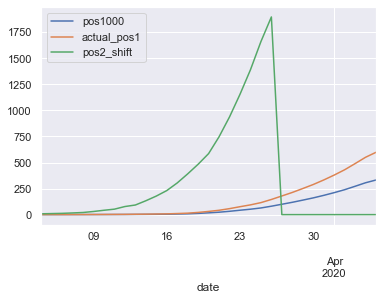

In [60]:
dfq["pos1000"] = dfq.positive/1000
dfq["pos2_shift"] = dfq["actual_pos2"].shift(-lag, fill_value=0)
dfq.plot(x="date", y=["pos1000", "actual_pos1", "pos2_shift"])

### SIR Fit

   direc: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: 12364.83840506176
 message: 'Optimization terminated successfully.'
    nfev: 51
     nit: 1
  status: 0
 success: True
       x: array([0.25749484, 0.10952481, 3.17821828])
Day 0 = 2020-03-04T00:00:00.000000000  (today=33)
Doubling time is about 2.69 days
Recovery time is about 6.33 days
Estimated initial infection was order of 3,178 poeple


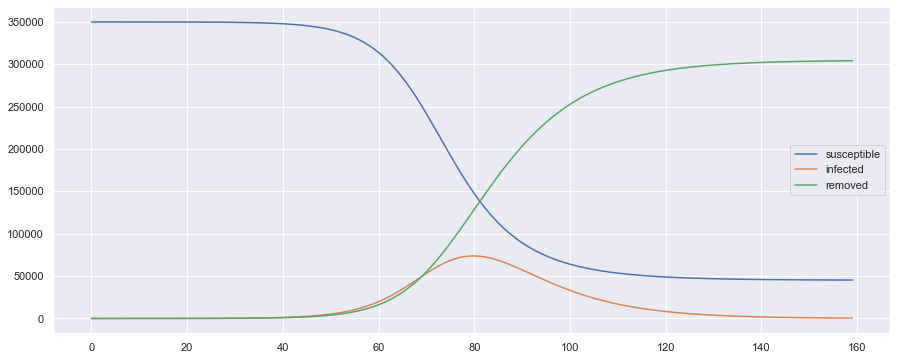

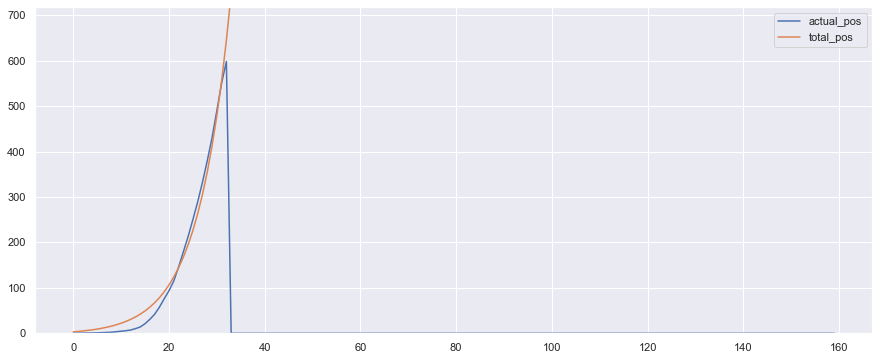

In [83]:
N=350000 
x0 = (0.25749545, 0.10952173, 3.17810689)  # beta, gamma, I0
c = dfq.actual_pos1.values
sf = SIR()
beta, gamma, I0 = sf.SIRFitter(c, N, x0)
print("Day 0 = {}  (today={})".format(dfq.date.values[0],
                            (pd.Timestamp.now() - dfq.date.values[0]).days))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))

   direc: array([[ 4.39494589e-03, -6.27570119e-04, -4.24520046e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 2.52502157e-03, -2.82173948e-04, -1.83504560e-01]])
     fun: 36437.66138003548
 message: 'Optimization terminated successfully.'
    nfev: 313
     nit: 6
  status: 0
 success: True
       x: array([0.3109645 , 0.10852456, 2.3722943 ])
Day 0 = 2020-02-23 00:00:00  (today=43)
Doubling time is about 2.23 days
Recovery time is about 6.39 days
Estimated initial infection was order of 2,372 poeple


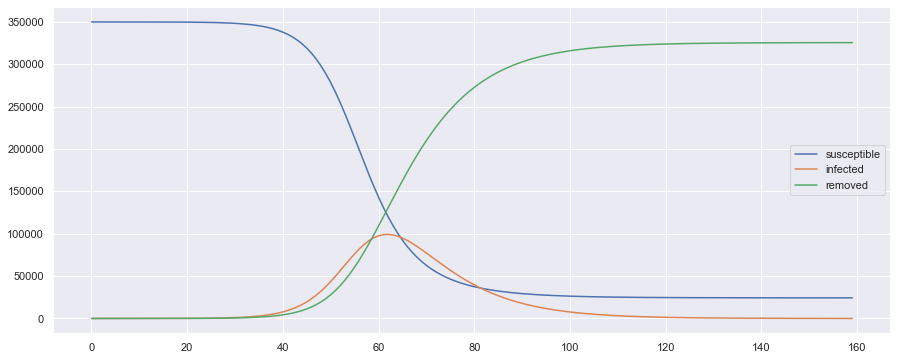

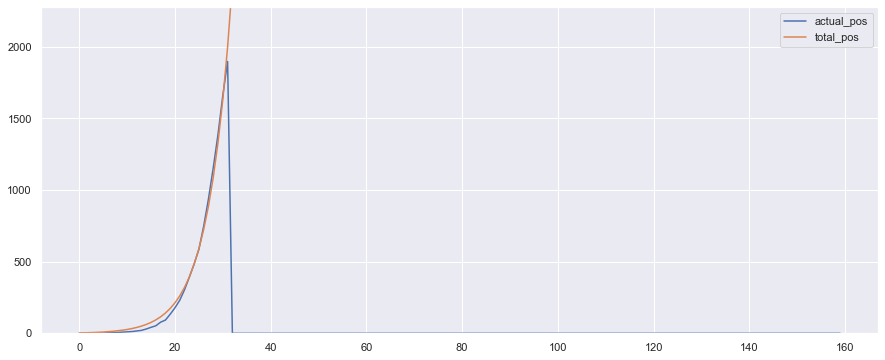

In [84]:
N=350000 
x0 = (0.25749545, 0.10952173, 3.17810689)  # beta, gamma, I0
c = dfq.actual_pos2.values[1:]
sf = SIR()
beta, gamma, I0 = sf.SIRFitter(c, N, x0)
print("Day 0 = {}  (today={})".format(dfq.date.values[0] - pd.Timedelta(days=lag),
                            (pd.Timestamp.now() - dfq.date.values[0]).days + lag))
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))

### SIR4: Try Varying beta as part of the model

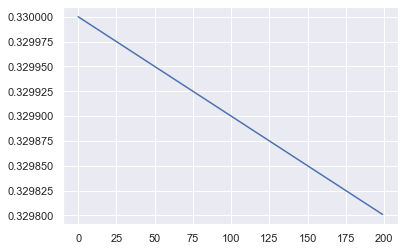

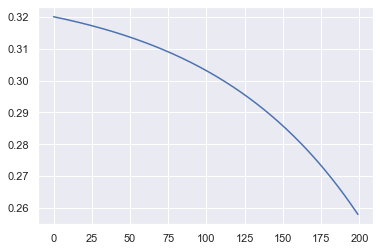

In [52]:
def g(alpha, beta0, t):
    return beta0 - alpha * t

def h(alpha, beta0, t):
    return beta0 - np.log(alpha) * alpha ** t

t = np.arange(0, 200, 1)
plt.plot(t, g(.000001, .33, t))
plt.show()
plt.plot(t, h(1.01, .33, t))
plt.show()

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[-9.62485671e-04,  2.50129175e-03,  1.94397141e-04,
        -2.88963094e-02],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00],
       [-1.21079759e-05,  3.50008624e-05,  1.16600917e-06,
        -2.78173591e-04]])
     fun: 4820.051828899741
 message: 'Optimization terminated successfully.'
    nfev: 824
     nit: 12
  status: 0
 success: True
       x: array([0.02379567, 0.82461163, 0.11536432, 0.14184256])
Day 0 = 2020-02-23 00:00:00  (today=43)
Doubling time (0) is about 0.84 days
Alpha = 0.02
Recovery time is about 6.01 days
Estimated initial infection was order of 141 poeple


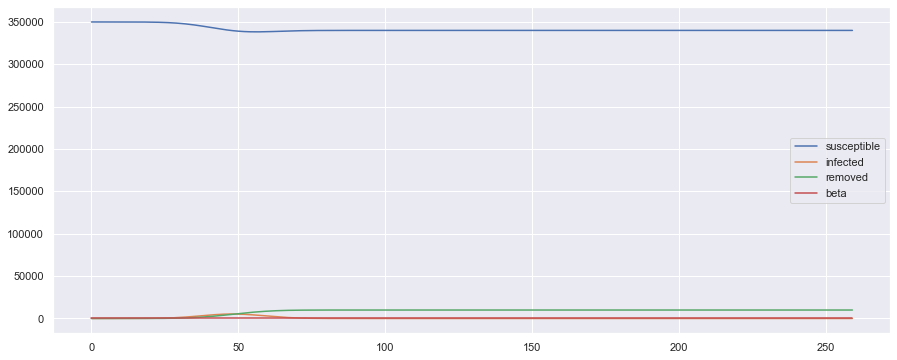

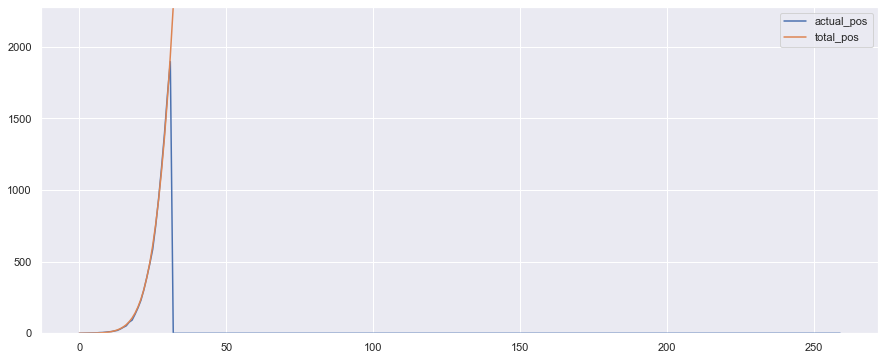

In [85]:
N=350000 
x0 = (0.03434576, 0.78682323, 0.08861404, 2.72153793)  # alpha, beta0, gamma, I0
c = dfq.actual_pos2.values[1:]
sf = SIR4()
alpha, beta0, gamma, I0 = sf.SIRFitter(c, N, x0)
print("Day 0 = {}  (today={})".format(dfq.date.values[0] - pd.Timedelta(days=lag),
                            (pd.Timestamp.now() - dfq.date.values[0]).days + lag))
print("Doubling time (0) is about {:.2f} days".format(np.log(2)/beta0))
print("Alpha = {:.2f}".format(alpha))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))

In [56]:
dfw, wsl = get_world_dataset_df_from_file()
dfw.head()

,Entity,state,Date,positive,date,lastUpdateEt,negative,pending
0,Afghanistan,AFG,"Dec 31, 2019",0,2019-12-31,2020-04-06 17:09:23.247386,0,0
1,Afghanistan,AFG,"Jan 1, 2020",0,2020-01-01,2020-04-06 17:09:23.247386,0,0
2,Afghanistan,AFG,"Jan 2, 2020",0,2020-01-02,2020-04-06 17:09:23.247386,0,0
3,Afghanistan,AFG,"Jan 3, 2020",0,2020-01-03,2020-04-06 17:09:23.247386,0,0
4,Afghanistan,AFG,"Jan 4, 2020",0,2020-01-04,2020-04-06 17:09:23.247386,0,0


/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[ 5.35525760e-04, -7.07713229e-04, -2.79716685e-02],
       [ 6.55304779e-03, -5.94497108e-03, -4.35491764e-01],
       [ 7.42331358e-04, -3.34371190e-04, -1.47852621e-02]])
     fun: 5069.5696759168195
 message: 'Optimization terminated successfully.'
    nfev: 357
     nit: 8
  status: 0
 success: True
       x: array([0.2269768 , 0.13508859, 0.2994105 ])
Doubling time is about 3.05 days
Recovery time is about 5.13 days
Estimated initial infection was order of 299 poeple


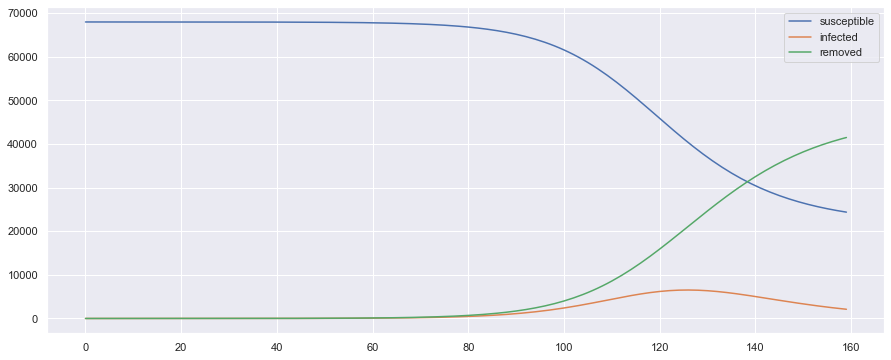

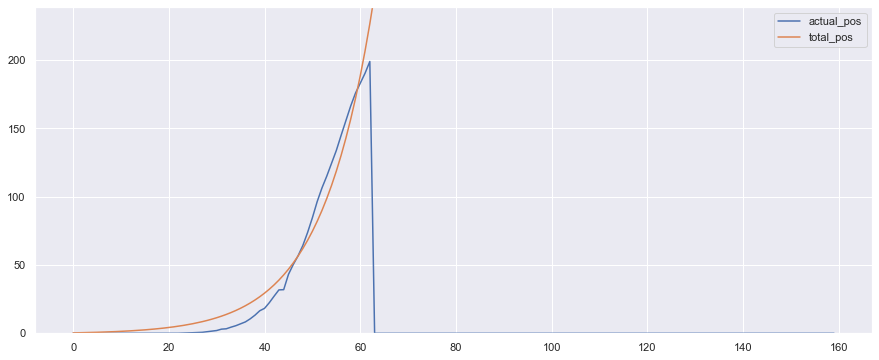

In [57]:
dfq, _ = get_state_df(dfw, "ITA")
pos_untested = 0.8
dfq["actual_pos"] = dfq.positive.values*(1 + pos_untested)/1000
N=68000 
R0=0
x0 = (0.33989521, 0.14846294, 1.09806025)
c = np.trim_zeros(dfq.actual_pos.values)
sf = SIR()
beta, gamma, I0 = sf.SIRFitter(c, N, x0)
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))

/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


   direc: array([[ 0.00014475, -0.00019573, -0.00085159],
       [ 0.00528153, -0.00479703, -0.03998829],
       [ 0.00095622, -0.00057958, -0.00266196]])
     fun: 1650.1996245932546
 message: 'Optimization terminated successfully.'
    nfev: 362
     nit: 8
  status: 0
 success: True
       x: array([0.20595015, 0.07019119, 0.03204354])
Doubling time is about 3.37 days
Recovery time is about 9.88 days
Estimated initial infection was order of 32 poeple


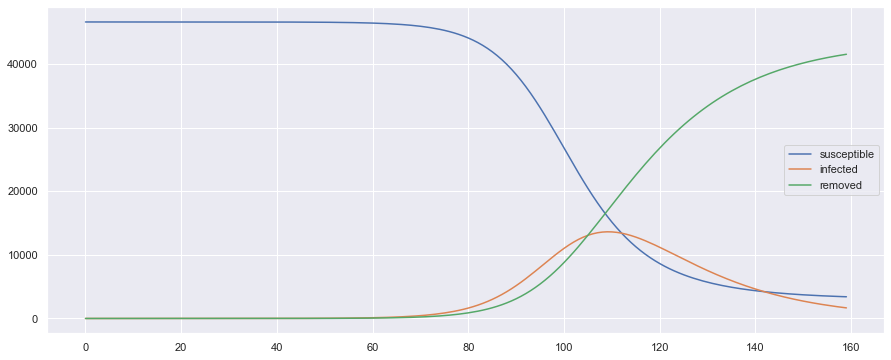

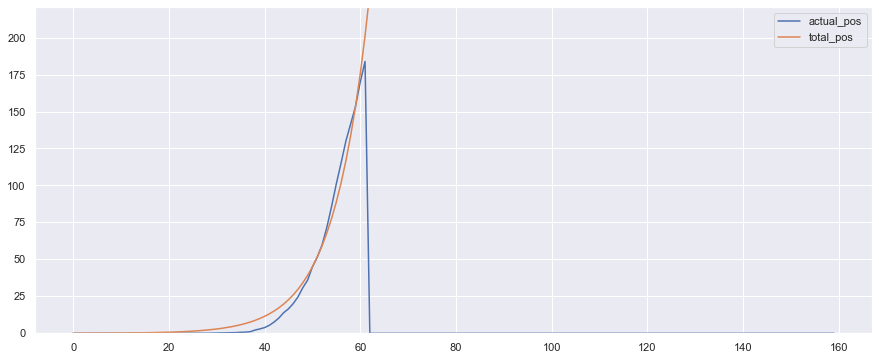

In [58]:
dfq, _ = get_state_df(dfw, "ESP")
pos_untested = 0.8
dfq["actual_pos"] = dfq.positive.values*(1 + pos_untested)/1000
N=46660 
R0=0
x0 = (0.3896, 0.08149, 0.1)
c = np.trim_zeros(dfq.actual_pos.values)
beta, gamma, I0 = sf.SIRFitter(c, N, x0)
print("Doubling time is about {:.2f} days".format(np.log(2)/beta))
print("Recovery time is about {:.2f} days".format(np.log(2)/gamma))
print("Estimated initial infection was order of {:,} poeple".format(int(1000*I0)))